# StochasticTITAN_2008

- **Paper**: A stochastic method for convective storm identification, tracking and nowcasting

- $\textbf{\textcolor{red}{Identification}}$:
    + **Identification**: the same as ETITAN_2007
    + **Sampling**: 
        + for each prev storm, uniformly drawing a set of particles inside storm.
        + num of particles = area of storm
        + assign equal weights for each particle

- $\textbf{\textcolor{blue}{Tracking}}$:
    + **Moton estimation**: Estimate the motion vector-field for each particle using TREC

    + **Matching**: 
        - $\textcolor{green}{\text{Partilce filtering}}$:
            + *Prediction*: make a forecast on each particle.
            + *Measurement*: for each assignment, count num or particles fall into the target

        - $\textcolor{green}{\text{Matching score (i,j)}}$:
            + $\operatorname{score}(i,j) = \operatorname{max}(NF_{i,j} / A_i; NF_{i,j} / A_j)$ 
            
            where $NF_{i,j}$ is the number of particles in storm $i$ predicted inside storm $j$ (later time)
            + if score > threshold => correct assignment

        - $\textcolor{green}{\text{Splitting \& Merging}}$: auto-handled by this approach.

        - $\textcolor{green}{\text{Deferred logic}}$: handle missing detection:
            + unmatched storm, still keep its particles

            + predict and update weights: $w_p = I_p / T_{min}$, where $T_{min}=35 dBz$ then normalized them (sum to 1)

            + compute the virtual centroid at that time

            + resample so that weights equal

            + use this virtual to predict the next frame. if matched => keep this state, otherwise, discard

- $\textbf{\textcolor{yellow}{Nowcasting}}$:
    + use TREC estimated vector motion on the centroid only to forecast.
    + fit linear interpolation model with exp smoothing.


In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2

## Prepare dataset

In [2]:
from src.preprocessing import read_image, windy_preprocessing_pipeline
from tqdm import tqdm

SOURCE_PATH = "data/image_old/philippines_13.269_123.832"

img_paths = [
    os.path.join(SOURCE_PATH, img_name) for img_name in sorted(os.listdir(SOURCE_PATH)) if img_name.endswith('.png')
][:40]
img_shape = read_image(img_paths[0]).shape       # get shape of the image
print(f"Image shape: {img_shape}")
print(f"-" * 20)

dbz_maps = []

for path in tqdm(img_paths, desc="Processing images and detecting storms"):
    img = read_image(path)
    dbz_maps.append(windy_preprocessing_pipeline(img))

print(f"Number of frames: {len(dbz_maps)}")

Image shape: (505, 1220, 3)
--------------------


Processing images and detecting storms: 100%|██████████| 40/40 [00:52<00:00,  1.31s/it]

Number of frames: 40


## 1. Identification

In [3]:
from src.identification import MorphContourIdentifier
from src.preprocessing import convert_contours_to_polygons, convert_polygons_to_contours
from src.cores.contours import StormObject, StormsMap
from datetime import datetime
from shapely import Polygon
from sklearn.cluster import KMeans
from copy import deepcopy
from shapely.affinity import translate

class ParticleStorm(StormObject):
    centroid: np.ndarray                # The centroid of the storm, represented as a numpy array with 2 elements (x, y)
    particles: list[np.ndarray] = []    # List of particles, each particle is represented as a numpy array with 2 elements (x, y)
    estimated_movement: tuple[float, float] = None  # Estimated movement vector (dx, dy)
    is_virtual: bool                    # Flag to indicate if the storm is virtual (not detected in current frame)

    def __init__(self, polygon: Polygon, centroid: tuple[float, float], density: float, id: str=""):
        super().__init__(contour=polygon, id=id)
        contour = convert_polygons_to_contours([polygon])[0]
        self.particles = self._sample_particles(contour, density)
        self.centroid = np.array(centroid).astype(np.int64)
        self.is_virtual = False

    def _sample_particles(self, contour: np.ndarray, density: float, shape = img_shape) -> np.ndarray:
        """
        Sample a list of particles inside the contour.

        Args:
            contour (np.ndarray): the list of points, in order, creating the contour.
            div (float, default): determine the number of particles = area / div.
        
        Returns:
            particles (np.ndarray): the list of particles.
        """
        # get the set of points bounded by the contour
        mask = np.zeros(shape=shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, [contour], color=1)
        points = np.argwhere(mask > 0)

        # cluster them 
        n_clusters = int(cv2.contourArea(contour) * density) + 1
        k_means = KMeans(n_clusters)
        k_means.fit(points)

        return k_means.cluster_centers_.astype(np.int64)

    def copy(self) -> "ParticleStorm":
        # Allocate new object without calling __init__
        new_obj = self.__class__.__new__(self.__class__)

        # Copy all attributes manually (deepcopy for safety)
        new_obj.__dict__ = deepcopy(self.__dict__)
        new_obj.id = "pred_" + new_obj.id

        return new_obj
    
    def make_move(self, displacement: np.ndarray):
        """
        Move the storm by the given displacement.
        """
        dx, dy = displacement
        self.contour = translate(self.contour, xoff=dx, yoff=dy)
        self.centroid = (self.centroid + displacement).astype(np.int64)
        self.particles = [particle + displacement for particle in self.particles]

    def get_num_particles(self):
        """
        Get the number of particles.
        """
        return len(self.particles)

    def retrieve_particles_movements(self, **kargs):
        """
        Retrieve the movements of the particles.
        """
        # retrieve parameters of estimatied-motion map.
        # grid_y = kargs.get("grid_y", np.array([]))
        # grid_x = kargs.get("grid_x", np.array([]))
        block_size = kargs.get("block_size", 16)
        vy = kargs.get("vy", np.array([]))
        vx = kargs.get("vx", np.array([]))

        if len(vy) == 0 or len(vx) == 0:
            raise ValueError("vy, vx must be provided.")

        y_idx = np.round(self.particles[:, 0] / block_size).astype(np.int64)
        x_idx = np.round(self.particles[:, 1] / block_size).astype(np.int64)

        dy = vy[y_idx, x_idx]
        dx = vx[y_idx, x_idx]

        x_centroid_idx = int(np.round(self.centroid[0] / block_size))
        y_centroid_idx = int(np.round(self.centroid[1] / block_size))

        self.estimated_movement = (vy[y_centroid_idx, x_centroid_idx], vx[y_centroid_idx, x_centroid_idx])

        return self.particles + np.stack((dy, dx), axis=-1).astype(np.int64)

    def count_particles_in_storm(self, particles: np.ndarray) -> int:
        """
        Count the number of particles inside the given contour.
        """
        mask = np.zeros(shape=img_shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, convert_polygons_to_contours([self.contour]), color=1)

        y_points = particles[:, 0]
        x_points = particles[:, 1]

        particle_mask = np.zeros(shape=img_shape[:2], dtype=np.uint8)
        particle_mask[y_points, x_points] = 1

        return np.sum(mask * particle_mask)

    def sample_new_particles(self, pred_particles: np.ndarray, dbz_map: np.ndarray, min_dbz: float):
        """
        Sample new particles to adapt the virtual storm based on the deferred logic.
        """
        x_points = pred_particles[:, 1]
        y_points = pred_particles[:, 0]

        weights = dbz_map[y_points, x_points] / min_dbz
        norm_weights = weights / (np.sum(weights) + 1e-9)

        re_sampled_indices = np.random.choice(
            np.arange(len(pred_particles)),
            size=len(self.particles),
            replace=True,
            p=norm_weights
        )
        self.particles = pred_particles[re_sampled_indices]


class DbzStormsMap(StormsMap):
    storms: list[ParticleStorm]
    dbz_map: np.ndarray

    def __init__(self, storms: list[ParticleStorm], time_frame: datetime, dbz_map: np.ndarray):
        """
        Beside 2 default attributes, also keep track of `dbz_map` for computin correlation.
        """
        super().__init__(storms, time_frame)
        self.dbz_map = dbz_map

    def _retrieve_movement(self, block: np.ndarray, search_region: np.ndarray) -> np.ndarray:
        block = block.astype(np.float32)
        search_region = search_region.astype(np.float32)
        result = cv2.matchTemplate(search_region, block, cv2.TM_CCOEFF_NORMED)
        return np.unravel_index(np.argmax(result), result.shape)

    def trec_estimate(self, other: "DbzStormsMap", **kargs) -> np.ndarray:
        """
        Generate a correlation map which show the movement between the current to other storm map.
        """
        block_size = kargs.get("block_size", 16)
        stride = kargs.get("stride", 16)
        local_buffer = kargs.get("buffer", 50)      # search region = block + expanded by local_buffer

        dbz_map_1 = self.dbz_map
        dbz_map_2 = other.dbz_map
        H, W = dbz_map_2.shape

        ys = list(range(0, H-block_size+1, stride))     # ys: list[start_idx of H-axis]
        xs = list(range(0, W-block_size+1, stride))     # xs: list[start_idx of W-axis]

        vy = np.zeros(shape=(len(ys), len(xs)))         # vy: keep the y-value of movement at corresponding position
        vx = np.zeros_like(vy)                          # vx: keep the y-value of movement at corresponding position

        for i, y in enumerate(ys):
            for j, x in enumerate(xs):
                block = dbz_map_1[y:y+block_size, x:x+block_size]
                if np.std(block) < 1e-3:    # case std is too small => continue
                    continue

                # otherwise: get the search region
                y_search_low, y_search_high = max(0,y-local_buffer), min(H,y + block_size + local_buffer)   # ensure the seach region is not overflow.
                x_search_low, x_search_high = max(0,x-local_buffer), min(W,x + block_size + local_buffer)

                search_region = dbz_map_2[y_search_low:y_search_high, x_search_low:x_search_high]
                dy, dx = self._retrieve_movement(block, search_region)

                y_best, x_best = y_search_low + dy, x_search_low + dx
                vy[i][j] = y_best - y
                vx[i][j] = x_best - x
        
        # predict the movement of particles in each storm
        predicted_particles_lst = []

        for storm in self.storms:
            predicted_particles = storm.retrieve_particles_movements(block_size=block_size, vy=vy, vx=vx)
            predicted_particles_lst.append(predicted_particles)

        return predicted_particles_lst

    def create_virtual_storm(self, storm: ParticleStorm, pred_particles: np.ndarray, min_dbz: float=35) -> ParticleStorm:
        """
        Create a virtual storm based on the given storm.
        """
        new_storm = storm.copy()
        new_storm.sample_new_particles(pred_particles, self.dbz_map, min_dbz=min_dbz)

        new_storm.id = "_".join(self.storms[0].id.split("_")[:-1] + [str(len(self.storms)), "virtual"])
        new_storm.is_virtual = True
        self.storms.append(new_storm)
   

In [4]:
THRESHOLD = 35
NUM_THRESHOLDS = 3
FILTER_AREA = 20
DENSITY = 0.1           # number of particles of a storm = area * DENSITY

Processing images and detecting storms: 100%|██████████| 40/40 [01:09<00:00,  1.73s/it]


--------------------
Time: 2025-01-08 03:10:44 | Detected storms: 12
Time: 2025-01-08 03:16:44 | Detected storms: 13
Time: 2025-01-08 03:22:45 | Detected storms: 17
Time: 2025-01-08 03:28:45 | Detected storms: 12
Time: 2025-01-08 03:34:45 | Detected storms: 12
Time: 2025-01-08 03:40:45 | Detected storms: 14
Time: 2025-01-08 03:46:46 | Detected storms: 14
Time: 2025-01-08 03:52:46 | Detected storms: 13
Time: 2025-01-08 03:58:46 | Detected storms: 12
Time: 2025-01-08 04:04:46 | Detected storms: 14
Time: 2025-01-08 04:10:47 | Detected storms: 13
Time: 2025-01-08 04:16:47 | Detected storms: 14
Time: 2025-01-08 04:22:47 | Detected storms: 23
Time: 2025-01-08 04:28:47 | Detected storms: 15
Time: 2025-01-08 04:34:48 | Detected storms: 15
Time: 2025-01-08 04:40:48 | Detected storms: 11
Time: 2025-01-08 04:46:48 | Detected storms: 9
Time: 2025-01-08 04:52:48 | Detected storms: 17
Time: 2025-01-08 04:58:49 | Detected storms: 15
Time: 2025-01-08 05:04:49 | Detected storms: 14
Time: 2025-01-08 05:

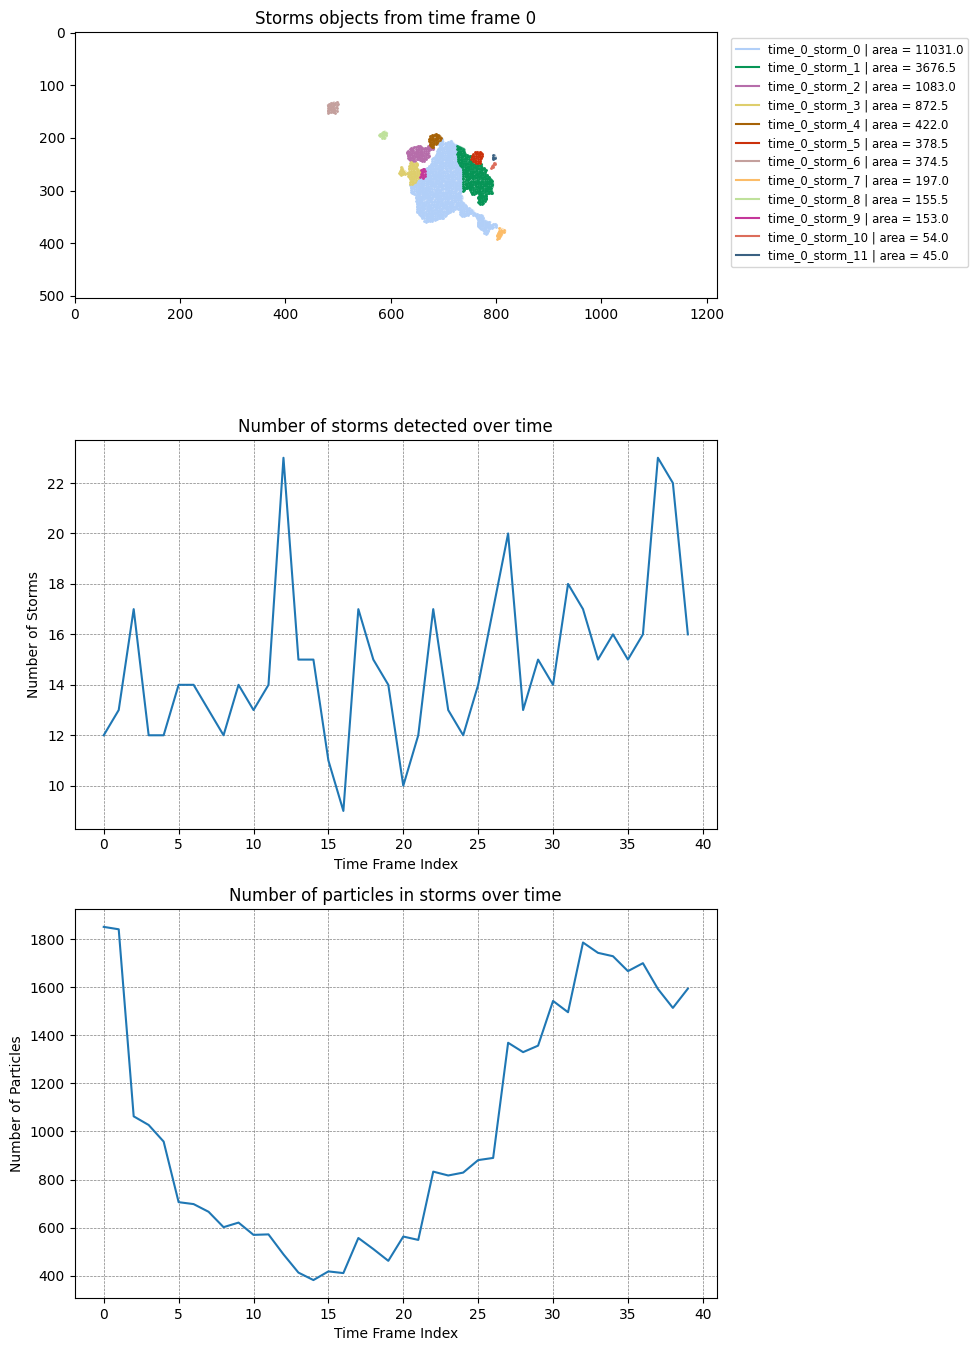

In [5]:
identifier = MorphContourIdentifier()
storms_map_time_lst: list[DbzStormsMap] = []

for time_idx, (path, dbz_map) in tqdm(enumerate(zip(img_paths, dbz_maps)), total=len(img_paths), desc="Processing images and detecting storms"):
    file_name = path.split("/")[-1].split(".")[0]

    # Convert contours to polygons
    contours = identifier.identify_storm(dbz_map, n_thresh=NUM_THRESHOLDS, threshold=THRESHOLD, filter_area=FILTER_AREA)
    polygons = convert_contours_to_polygons(contours)
    polygons = sorted(polygons, key=lambda x: x.area, reverse=True)

    # Construct storms map
    time_frame = datetime.strptime(file_name, "%Y%m%d-%H%M%S")

    # Keep list of storms
    storms = []

    for idx, polygon in enumerate(polygons):
        contour = convert_polygons_to_contours([polygon])[0]

        # Create the mask of current storm
        mask = np.zeros_like(dbz_map, dtype=np.uint8)
        cv2.fillPoly(mask, contour, color=1)

        # Extract DBZ values inside mask
        weights = dbz_map * mask

        # Create coordinate grids
        y_idx, x_idx = np.indices(dbz_map.shape)

        # Compute weighted centroid
        total_weight = weights.sum()
        if total_weight == 0:
            centroid = (np.nan, np.nan)  # or fallback
        else:
            cx = (x_idx * weights).sum() / total_weight
            cy = (y_idx * weights).sum() / total_weight
            centroid = (int(cx), int(cy))

        storms.append(ParticleStorm(
                polygon, centroid=centroid, id=f"time_{time_idx}_storm_{idx}", density=DENSITY
            ))
        
    storms_map = DbzStormsMap(storms, time_frame=time_frame, dbz_map=dbz_map)
    storms_map_time_lst.append(storms_map)

print("-"*20)

# print number of detected storms over time
for storms_map in storms_map_time_lst:
    print(f"Time: {storms_map.time_frame.strftime('%Y-%m-%d %H:%M:%S')} | Detected storms: {len(storms_map.storms)}")

print("-"*20)
# print number of detected storms over time
plt.figure(figsize=(10, 14))

plt.subplot(3,1,1)
blank_image = np.ones(img_shape, dtype=np.uint8) * 255

for storm in storms_map_time_lst[0].storms:
    color = np.random.randint(0, 255, size=3).tolist()
    x_centroid, y_centroid = storm.centroid
    particles = storm.particles
    x_points, y_points = particles[:, 1], particles[:, 0]
    
    plt.plot([], [], color=np.array(color)/255.0, label=f"{storm.id} | area = {storm.contour.area:.1f}")
    plt.scatter(x_points, y_points, color=np.array(color)/255.0, s=1)
    # plt.scatter(x_centroid, y_centroid, color=np.array(color)/255.0, s=5)
    cv2.drawContours(blank_image, convert_polygons_to_contours([storm.contour]), -1, color, thickness=1)

plt.legend(loc="upper right", fontsize='small', ncol=1, bbox_to_anchor=(1.4, 1))
plt.imshow(blank_image,cmap="gray")
plt.title('Storms objects from time frame 0')
plt.tight_layout()


plt.subplot(3,1,2)
number_of_storms = [len(storms_map.storms) for storms_map in storms_map_time_lst]
plt.plot(range(len(number_of_storms)), number_of_storms)
plt.title('Number of storms detected over time')
plt.xlabel('Time Frame Index')
plt.ylabel('Number of Storms')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.tight_layout()

plt.subplot(3,1,3)
number_of_storms = [np.sum([storm.get_num_particles() for storm in storms_map.storms]) for storms_map in storms_map_time_lst]
plt.plot(range(len(number_of_storms)), number_of_storms)
plt.title('Number of particles in storms over time')
plt.xlabel('Time Frame Index')
plt.ylabel('Number of Particles')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

plt.tight_layout()
plt.show()

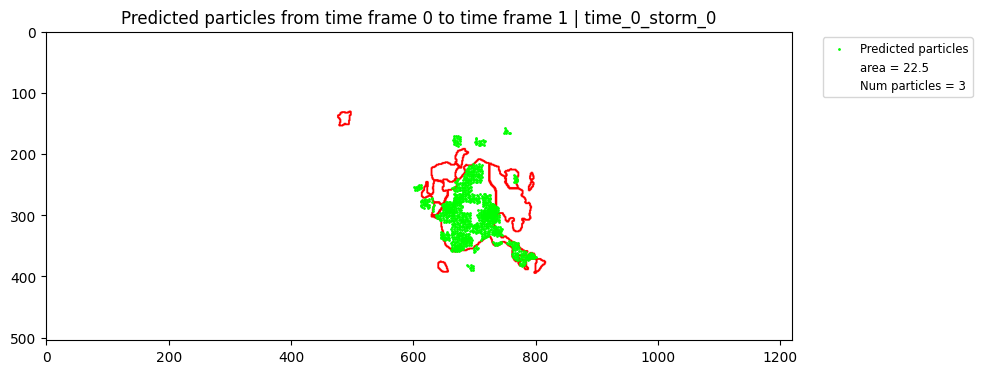

In [6]:
storms_map_1 = storms_map_time_lst[0]
storms_map_2 = storms_map_time_lst[1]

pred_particles_lst = storms_map_1.trec_estimate(storms_map_2)

storm_idx = 0

blank_image = np.ones(img_shape, dtype=np.uint8) * 255
prev_storm = storms_map_1.storms[storm_idx]
particles = pred_particles_lst[storm_idx]

plt.figure(figsize=(10, 10))

x_points, y_points = particles[:, 1], particles[:, 0]
plt.scatter(x_points, y_points, color=(0,1.0,0), s=1, label=f"Predicted particles")

for storm in storms_map_2.storms:
    # color = np.random.randint(0, 255, size=3).tolist()
    cv2.drawContours(blank_image, convert_polygons_to_contours([storm.contour]), -1, (255,0,0), thickness=2)

plt.plot([], [], color=(1,1,1), label=f"area = {storm.contour.area:.1f}")
plt.plot([], [], color=(1,1,1), label=f"Num particles = {storm.get_num_particles()}")
plt.legend(loc="upper right", fontsize='small', ncol=1, bbox_to_anchor=(1.25, 1))

plt.imshow(blank_image)
plt.title(f'Predicted particles from time frame 0 to time frame 1 | {prev_storm.id}')
plt.tight_layout()
plt.show()

## 2. Tracking

### 2.1 Implementation of `Matcher`

- **Idea**:

    + Make a forecast for each particle using TREC.
    
    + Check where each fall into for each particle.

    + Matching pair => storms with high overlapping (number of predicted particles fall into the new position)

In [7]:
from src.tracking import BaseMatcher, BaseTrackingHistory, BaseTracker

class Matcher(BaseMatcher):
    max_velocity: float     # unit: pixel/hr

    def __init__(self, max_velocity: float):
        self.max_velocity = max_velocity
    
    def _construct_disparity_matrix(self, object_lst1, object_lst2):
        pass

    def match_storms(
            self, storm_map_1: DbzStormsMap, storm_map_2: DbzStormsMap, 
            correlation_block_size: int = 16, matching_overlap_threshold: float = 0.5
        ) -> np.ndarray:
        """
        Match storms between 2 time frame.

        Args:
            storm_map_1 (StormsMap): storm map in the 1st frame.
            storm_map_2 (StormsMap): storm map in the 2nd frame.
        
        Returns:
            assignments (np.ndarray): Array of (prev_idx, curr_idx) pairs representing matched storms.
            pred_particles_lst (list[np.ndarray]): List of predicted particles for each storm in storm_map_1.
        """
        dt = (storm_map_2.time_frame - storm_map_1.time_frame).seconds / 3600.0    # in hours
        buffer = int(self.max_velocity * dt)    # in pixels
        pred_particles_lst = storm_map_1.trec_estimate(storm_map_2, block_size=correlation_block_size, stride=correlation_block_size, buffer=buffer)
        
        NF_matrix = np.zeros((len(storm_map_1.storms), len(storm_map_2.storms)), dtype=np.float64)
        for i, pred_particles in enumerate(pred_particles_lst):
            for j, storm_2 in enumerate(storm_map_2.storms):
                NF_matrix[i][j] = storm_2.count_particles_in_storm(pred_particles) / min([storm_2.get_num_particles(), len(pred_particles)])
        
        return np.argwhere(NF_matrix >= matching_overlap_threshold), pred_particles_lst

In [8]:
BLOCK_SIZE = 16
OVERLAP_THRESHOLD = 0.45
MAX_VELOCITY = 500              # pixel/hr

prev_storms_map = storms_map_time_lst[0]
curr_storms_map = storms_map_time_lst[1]

curr_storms_map.storms = [storm for storm in curr_storms_map.storms if storm.is_virtual == False]

matcher = Matcher(MAX_VELOCITY)
assignments, pred_particles_lst = matcher.match_storms(prev_storms_map, curr_storms_map, correlation_block_size=BLOCK_SIZE, matching_overlap_threshold=OVERLAP_THRESHOLD)

mapping_prev = {}
mapping_curr = {}
for prev_idx, curr_idx in assignments:
    if int(prev_idx) not in mapping_prev:
        mapping_prev[int(prev_idx)] = []
    mapping_prev[int(prev_idx)].append(int(curr_idx))

    if int(curr_idx) not in mapping_curr:
        mapping_curr[int(curr_idx)] = []
    mapping_curr[int(curr_idx)].append(int(prev_idx))

prev_unassigned = [idx for idx in range(len(prev_storms_map.storms)) if idx not in mapping_prev.keys() and prev_storms_map.storms[idx].is_virtual == False]
for idx in prev_unassigned:
    pred_particles = pred_particles_lst[idx]
    curr_storms_map.create_virtual_storm(prev_storms_map.storms[idx], pred_particles=pred_particles, min_dbz=THRESHOLD)

for storm in curr_storms_map.storms:
    print(f"{storm.id} | area = {storm.contour.area:.1f} | num_particles = {storm.get_num_particles()} | is_virtual = {storm.is_virtual}")

time_1_storm_0 | area = 10790.0 | num_particles = 1080 | is_virtual = False
time_1_storm_1 | area = 3468.5 | num_particles = 347 | is_virtual = False
time_1_storm_2 | area = 1069.0 | num_particles = 107 | is_virtual = False
time_1_storm_3 | area = 864.0 | num_particles = 87 | is_virtual = False
time_1_storm_4 | area = 518.5 | num_particles = 52 | is_virtual = False
time_1_storm_5 | area = 431.0 | num_particles = 44 | is_virtual = False
time_1_storm_6 | area = 333.0 | num_particles = 34 | is_virtual = False
time_1_storm_7 | area = 311.5 | num_particles = 32 | is_virtual = False
time_1_storm_8 | area = 230.5 | num_particles = 24 | is_virtual = False
time_1_storm_9 | area = 185.5 | num_particles = 19 | is_virtual = False
time_1_storm_10 | area = 61.0 | num_particles = 7 | is_virtual = False
time_1_storm_11 | area = 48.5 | num_particles = 5 | is_virtual = False
time_1_storm_12 | area = 22.5 | num_particles = 3 | is_virtual = False
time_1_storm_13_virtual | area = 422.0 | num_particles = 43

### 2.2 Implementation of `TrackingHistory`

- **Idea**: keep track of storms evolution over time.

- **Deferred logic**: handle missing detection:

    + unmatched storm, still keep its particles

    + predict and update weights: $w_p = I_p / T_min$, then normalized them (sum to 1)

    + compute the virtual centroid at that time

    + resample so that weights equal
    
    + use this virtual to predict the next frame. if matched => keep this state, otherwise, discard

- **Public methods**:
    - $\textcolor{yellow}{\text{forecast}}$: forecast the next position of current storm track.
    - $\textcolor{yellow}{\text{update}}$: receive the mapping of current storms and update the track.

In [9]:
from copy import deepcopy
from shapely import Polygon
from shapely.affinity import translate
from enum import Enum

class TrackStatus(Enum):
    ACTIVE = 0
    VIRTUAL = 1     # case the storm is missing in current frame, but we still keep it for some frames to see if it re-appears
    EXPIRED = 2

    def print_status(self):
        if self == TrackStatus.ACTIVE:
            return "Active"
        elif self == TrackStatus.VIRTUAL:
            return "Virtual"
        elif self == TrackStatus.EXPIRED:
            return "Expired"

class TrackingHistory(BaseTrackingHistory):
    virtual_list: list[int] = []   # list of track idx which are currently virtual

    def __init__(self, storms_map: StormsMap):
        self.tracks = [self._initialize_track(storm, storms_map.time_frame) for storm in storms_map.storms]
        self.storm_dict = {storm.id: idx for idx, storm in enumerate(storms_map.storms)}
        self.active_list = list(range(len(self.storm_dict)))
        self.virtual_list = []
    
    def _initialize_track(self, storm: ParticleStorm, time_frame: datetime):
        return {"storm_lst": [storm], "frame": [time_frame], "movement": [], "status": TrackStatus.ACTIVE}
    
    def _copy_track(self, track: dict) -> dict:
        return {
            "storm_lst": deepcopy(track["storm_lst"]),
            "frame": deepcopy(track["frame"]),
            "movement": deepcopy(track["movement"]),
            "status": track["status"]
        }
    
    def _get_track(self, storm_id: str) -> tuple[dict, float]:
        """
        Get the track of storm with storm_id, if there is no track found, raise `KeyError`.

        Args:
            storm_id (str): id of the storm
        
        Returns:
            track, is_active (tuple[dict, bool]): the track of the storm and whether it is active.
        """
        if storm_id not in self.storm_dict:
            raise KeyError(f"Storm not found in the current track.")
        track_id = self.storm_dict[storm_id]
        return self.tracks[track_id], track_id in self.active_list

    def _interpolate_velocity(self, velocity_lst: list[np.ndarray], alpha_decay: float = 0.5) -> np.ndarray:
        """
        Interpolate the velocity using weighted average with decay factor alpha_decay.

        Args:
            velocity_lst (list[np.ndarray]): list of velocity vectors.
            alpha_decay (float, default=0.5): the decay factor.

        Returns:
            interpolated_velocity (np.ndarray): the interpolated velocity.
        """
        if len(velocity_lst) == 1:
            return velocity_lst[0]
        
        weights = np.array([alpha_decay**i for i in range(len(velocity_lst))])
        total_w = np.sum(weights)
        return np.sum([displ * w / total_w for displ, w in zip(velocity_lst[::-1], weights)], axis=0)

    def _handle_merge(self, merge_lst: list[dict]) -> np.ndarray:
        """
        Combine the list of storms to generate the parent storm history.
        
        Args:
            merge_lst (list[dict]): contains information about the storm, including movement history, area.
        """
        weights = np.array([s["area"] for s in merge_lst])
        movements_lst = [np.array(s["movement"])[::-1] for s in merge_lst]  # revert for matching the time.

        combined_len = max([len(movements) for movements in movements_lst]) # length of parent = max length of its child
        parent_movement = np.zeros(shape=(combined_len, 2), dtype=np.float64)

        # for each time, if the
        for i in range(combined_len):
            total_value, total_weight = np.zeros(shape=(2,)), 0
            for weight, movements in zip(weights, movements_lst):
                if len(movements) <= i:
                    continue
                total_value += movements[i]
                total_weight += weight
            parent_movement[i] = total_value / total_weight
        
        return parent_movement[::-1]

    def forecast(self, storm_id: str, dt: float, default_motion: np.ndarray = np.array([0,0])) -> ParticleStorm:
        """
        Make a forecast for the next position of the track with track_id using the history.
        
        Args:
            storm_id (int): id of the storm.
            dt (float): the interval between the current and next frame.
            default_motion (np.ndarray, default): default motion used in case there is no recorded history. Unit: pixel/hr.
        
        Returns:
            storm (CentroidStorm): the estimated storm in the next frame.
        """
        track, status = self._get_track(storm_id)
        if not status:
            print(f"⚠️ Storm has been expired")
        
        curr_storm: ParticleStorm = track["storm_lst"][-1]
        velocity_lst = track["movement"]
        if len(velocity_lst) == 0:
            dx, dy = default_motion * dt
        else:
            dx, dy = self._interpolate_velocity(velocity_lst) * dt

        new_storm = curr_storm.copy()
        new_storm.make_move(np.array([dx, dy]))

        return new_storm
    
    def update(
            self, prev_mapping: dict, curr_mapping: dict, prev_storms_map: DbzStormsMap, curr_storms_map: DbzStormsMap,
        ):
        """
        Update the tracking history using the new mapping data.

        Args:
            prev_mapping (dict): key -> idx of prev storm; items -> list[idx of curr storm].
            curr_mapping (dict): key -> idx of curr storm; items -> list[idx of prev storm].
            time_frame (datetime): time of current mapping.
        """
        active_lst = []         # update the new active list
        virtual_lst = []        # update the new virtual list
        curr_time = curr_storms_map.time_frame
        prev_time = prev_storms_map.time_frame

        dt = (curr_time - prev_time).seconds / 3600

        def get_movement(prev_idx, curr_idx):
            """
            Get the centroid movement of 2 storms, scaled to pixel/hr.
            """
            displacement = prev_storms_map.storms[prev_idx].estimated_movement 
            if displacement is None:
                raise ValueError(f"Storm {prev_storms_map.storms[prev_idx].id} is None")
            
            return np.array(displacement) / dt
        
        for curr_idx, matched in curr_mapping.items():
            curr_storm = curr_storms_map.storms[curr_idx]

            ## Case 1: no previous matching => create the new track.
            if len(matched) == 0:
                # create new track
                self.tracks.append(self._initialize_track(curr_storm, curr_time))

                # update storm dict and active_lst
                new_tid = len(self.tracks) - 1
                self.storm_dict[curr_storm.id] = new_tid
                active_lst.append(new_tid)
            
            # Case 2: more than 1 parent storms => merged
            elif len(matched) > 1:
                merge_lst = []
                max_area = 0
                track_id = None

                for prev_idx in matched:
                    prev_storm = prev_storms_map.storms[prev_idx]   # get the previous storm

                    track = self._get_track(prev_storm.id)[0]       # get the corresponding track
                    area = prev_storm.contour.area
                    if area > max_area:
                        max_area = area
                        track_id = self.storm_dict[prev_storm.id]   # track with highest area will be extended, others are terminated
                    
                    merge_lst.append({
                        "area": prev_storm.contour.area,
                        "movement": track["movement"] + [get_movement(prev_idx, curr_idx)]
                    })
                
                if track_id in active_lst:
                    current_track = self._copy_track(self.tracks[track_id])
                    current_track["movement"] = current_track["movement"][:-1]      # remove the last movement, as it will be re-computed
                    current_track["storm_lst"] = current_track["storm_lst"][:-1]    # remove the last storm, as it will be re-computed
                    current_track["frame"] = current_track["frame"][:-1]            # remove the last frame, as it will be re-computed
                    self.tracks.append(current_track)
                    track_id = len(self.tracks) - 1
                else:
                    current_track = self.tracks[track_id]
                
                movement_history = self._handle_merge(merge_lst)    # resolve the history
                current_track["storm_lst"].append(curr_storm)
                current_track["movement"] = list(movement_history)  # update the movement
                current_track["frame"].append(curr_time)

                # update storm dict & active lst
                active_lst.append(track_id)
                self.storm_dict[curr_storm.id] = track_id
            
            # Case 3: only 1 parent storm
            else:
                prev_idx = matched[0]
                prev_storm = prev_storms_map.storms[prev_idx]   # get the previous storm

                # case 3.1: parent has more than 2 childrens => split
                ##   => movement = combined centroid - previous storm centroid
                if len(prev_mapping[prev_idx]) > 1:
                    # print(f"⚠️ Storm {prev_storm.id} has split into {[curr_storms_map.storms[j].id for j in prev_mapping[prev_idx]]}")
                    # get the combined centroid using area as weight.
                    weight_centroids = [(curr_storms_map.storms[j].centroid, curr_storms_map.storms[j].contour.area) \
                                          for j in prev_mapping[prev_idx]]
                    total_w = np.sum([w for _, w in weight_centroids])
                    combined_centroid = np.sum([centroid * w / total_w for centroid, w in weight_centroids], axis=0)

                    # get the movement from parent -> combined centroid
                    movement = (combined_centroid - prev_storm.centroid) / dt

                    # copy the previous track into the new, then update parameters.
                    track_id = self.storm_dict[prev_storm.id]

                    new_track = self._copy_track(self._get_track(prev_storm.id)[0])
                    if track_id in active_lst:
                        new_track["movement"] = new_track["movement"][:-1]      # remove the last movement, as it will be re-computed
                        new_track["storm_lst"] = new_track["storm_lst"][:-1]    # remove the last storm, as it will be re-computed
                        new_track["frame"] = new_track["frame"][:-1]            # remove the last frame, as it will be re-computed

                    self.tracks.append(new_track)
                    new_track["storm_lst"].append(curr_storm)
                    new_track["movement"].append(movement)
                    new_track["frame"].append(curr_time)

                    new_tid = len(self.tracks) - 1
                    self.storm_dict[curr_storm.id] = new_tid
                    active_lst.append(new_tid)

                # case 3.2: one-to-one parent-child
                else:
                    # update the current track
                    movement = get_movement(prev_idx, curr_idx)
                    current_track = self._get_track(prev_storm.id)[0]
                    current_track["storm_lst"].append(curr_storm)
                    current_track["movement"].append(movement)
                    current_track["frame"].append(curr_time)

                    track_id = self.storm_dict[prev_storm.id]
                    self.storm_dict[curr_storm.id] = track_id
                    active_lst.append(track_id)
            
            if curr_storm.is_virtual:
                virtual_lst.append(self.storm_dict[curr_storm.id])

        self.virtual_list = sorted(virtual_lst)
        self.active_list = sorted(active_lst)

    def print_tracks(self):
        def _is_valid_track(id: int, track: dict) -> bool:
            _get_time = lambda x: int(x.id.split("_")[1])
            current_time = _get_time(track["storm_lst"][0])
            for storm in track["storm_lst"][1:]:
                next_time = _get_time(storm)
                if not next_time == current_time + 1:
                    return False
                current_time = next_time
            
            return True
                
        for id, track in enumerate(self.tracks):
            if not _is_valid_track(id, track):
                print(f"Track {id:2d} is invalid, skipping...")
                continue

            print(f"Track {id:2d}. " + " -> ".join(storm.id for storm in track["storm_lst"]))
            print(f"Lifespan: {len(track["frame"])}")
            print(f"Last track: {track["frame"][-1].strftime('%Y-%m-%d %H:%M:%S')}")
            if id in self.active_list:
                print(f"Status: Active")
            elif id in self.virtual_list:
                print(f"Status: Virtual")
            else:
                print(f"Status: Expired")
            print(f"-" * 50)

### 2.3 Implementation of `Tracker`

- **Idea**: a common class that keep everything about the tracking step.

- **Methods**:
    - $\textcolor{yellow}{\text{fit}}$: receive the list of storms over time, match them step-by-step and record the tracking history.
    - $\textcolor{yellow}{\text{predict}}$: predict the next position of the current track.

In [10]:
from src.cores.metrics import pod_score, far_score, csi_score
from src.tracking import BaseTracker

class Tracker(BaseTracker):
    matcher: Matcher
    tracker: TrackingHistory

    def __init__(self, max_velocity: float):
        self.matcher = Matcher(max_velocity=max_velocity)
        
    def fit(self, storms_map_time_lst: list[DbzStormsMap], test=False):
        self.tracker = TrackingHistory(storms_map_time_lst[0])
        csi_scores, far_scores, pod_scores, frames = [], [], [], []

        for idx in range(0, len(storms_map_time_lst)-1):
            # get the current maps
            prev_storms_map, curr_storms_map = storms_map_time_lst[idx], storms_map_time_lst[idx+1]
            curr_storms_map.storms = [storm for storm in curr_storms_map.storms if storm.is_virtual == False]

            dt = (curr_storms_map.time_frame - prev_storms_map.time_frame).seconds / 3600   # scaled to hours

            # matching
            assignments, pred_particles_lst = self.matcher.match_storms(prev_storms_map, curr_storms_map)

            ## mapping: dict where key -> index of storm; value -> list of tuple[storm_id]
            ## Note: split & merge are already handled by the matcher 
            mapping_prev = {}
            mapping_curr = {int(curr_idx): [] for curr_idx in range(len(curr_storms_map.storms))}   # ensure all current storms are in the mapping_curr

            for prev_idx, curr_idx in assignments:
                if int(prev_idx) not in mapping_prev:
                    mapping_prev[int(prev_idx)] = []
                mapping_prev[int(prev_idx)].append(int(curr_idx))

                mapping_curr[int(curr_idx)].append(int(prev_idx))
            
            # handle un-assigned prev storms (create virtual storms)
            prev_unassigned = [idx for idx in range(len(prev_storms_map.storms)) if idx not in mapping_prev.keys() and prev_storms_map.storms[idx].is_virtual == False]
            for prev_idx in prev_unassigned:
                pred_particles = pred_particles_lst[prev_idx]
                curr_storms_map.create_virtual_storm(prev_storms_map.storms[prev_idx], pred_particles=pred_particles, min_dbz=THRESHOLD)

                mapping_prev[int(prev_idx)] = [len(curr_storms_map.storms)-1]   # the last storm is the newly created virtual storm
                mapping_curr[len(curr_storms_map.storms)-1] = [int(prev_idx)]
            
            if test:
                pred_storms_map = DbzStormsMap([
                        self.tracker.forecast(storm.id, dt)
                        for storm in prev_storms_map.storms
                    ], time_frame=curr_storms_map.time_frame, dbz_map=curr_storms_map.dbz_map)
                csi_scores.append(csi_score(pred_storms_map, curr_storms_map))
                far_scores.append(far_score(pred_storms_map, curr_storms_map))
                pod_scores.append(pod_score(pred_storms_map, curr_storms_map))
                frames.append(curr_storms_map.time_frame)

            self.tracker.update(mapping_prev, mapping_curr, prev_storms_map, curr_storms_map)

        if test:
            return csi_scores, far_scores, pod_scores, frames

    def predict(self, storm: ParticleStorm, dt: float):
        """
        Predict the future state of a storm given its current state and a time delta.
        """
        try:
            return self.tracker.forecast(storm.id, dt)
        except KeyError:
            print(f"❗ Storm not found on the track. `None` will be returned.")
            return None

In [11]:
MAX_VELOCITY = 500  # unit: pixel/hr

tracker = Tracker(max_velocity=MAX_VELOCITY)
csi_scores, far_scores, pod_scores, frames = tracker.fit(storms_map_time_lst, test=True)

tracker.tracker.print_tracks()

Track  0. time_0_storm_0 -> time_1_storm_0
Lifespan: 2
Last track: 2025-01-08 03:16:44
Status: Expired
--------------------------------------------------
Track  1. time_0_storm_1 -> time_1_storm_1 -> time_2_storm_17_virtual
Lifespan: 3
Last track: 2025-01-08 03:22:45
Status: Expired
--------------------------------------------------
Track  2. time_0_storm_2 -> time_1_storm_2 -> time_2_storm_18_virtual
Lifespan: 3
Last track: 2025-01-08 03:22:45
Status: Expired
--------------------------------------------------
Track  3. time_0_storm_3 -> time_1_storm_3 -> time_2_storm_19_virtual
Lifespan: 3
Last track: 2025-01-08 03:22:45
Status: Expired
--------------------------------------------------
Track  4. time_0_storm_4 -> time_1_storm_13_virtual
Lifespan: 2
Last track: 2025-01-08 03:16:44
Status: Expired
--------------------------------------------------
Track  5. time_0_storm_5 -> time_1_storm_4 -> time_2_storm_20_virtual
Lifespan: 3
Last track: 2025-01-08 03:22:45
Status: Expired
----------

## 3. Nowcasting

In [12]:
from src.cores.metrics import pod_score, far_score, csi_score

bm_pod_scores = []
bm_far_scores = []
bm_csi_scores = []

print("Naive nowcasting prediction: Only using the last map without any motion update")
print("Results:")
for idx in range(len(storms_map_time_lst)-1):
    prev_storm = storms_map_time_lst[idx]
    curr_storm = storms_map_time_lst[idx+1]
    bm_pod_scores.append(pod_score(prev_storm, curr_storm))
    bm_far_scores.append(far_score(prev_storm, curr_storm))
    bm_csi_scores.append(csi_score(prev_storm, curr_storm))
    print(f"\tTime {curr_storm.time_frame.strftime('%Y-%m-%d %H:%M:%S')} | POD: {pod_score(prev_storm, curr_storm):.4f} | FAR: {far_score(prev_storm, curr_storm):.4f} | CSI: {csi_score(prev_storm, curr_storm):.4f}")

indexes = range(len(bm_pod_scores))
scores = [bm_pod_scores, bm_far_scores, bm_csi_scores]
titles = ['Probability of Detection Over Time', 'False Alarm Rate Over Time', 'Critical Success Index Over Time']

Naive nowcasting prediction: Only using the last map without any motion update
Results:
	Time 2025-01-08 03:16:44 | POD: 0.9109 | FAR: 0.0660 | CSI: 0.8658
	Time 2025-01-08 03:22:45 | POD: 0.7339 | FAR: 0.3065 | CSI: 0.6236
	Time 2025-01-08 03:28:45 | POD: 0.8735 | FAR: 0.3868 | CSI: 0.5723
	Time 2025-01-08 03:34:45 | POD: 0.8781 | FAR: 0.1666 | CSI: 0.7559
	Time 2025-01-08 03:40:45 | POD: 0.5781 | FAR: 0.4209 | CSI: 0.4704
	Time 2025-01-08 03:46:46 | POD: 0.8593 | FAR: 0.2099 | CSI: 0.7166
	Time 2025-01-08 03:52:46 | POD: 0.4648 | FAR: 0.4951 | CSI: 0.3325
	Time 2025-01-08 03:58:46 | POD: 0.8263 | FAR: 0.2746 | CSI: 0.6446
	Time 2025-01-08 04:04:46 | POD: 0.7460 | FAR: 0.2056 | CSI: 0.6526
	Time 2025-01-08 04:10:47 | POD: 0.5629 | FAR: 0.0411 | CSI: 0.7514
	Time 2025-01-08 04:16:47 | POD: 0.8767 | FAR: 0.3217 | CSI: 0.6339
	Time 2025-01-08 04:22:47 | POD: 0.5125 | FAR: 0.2810 | CSI: 0.4817
	Time 2025-01-08 04:28:47 | POD: 0.7187 | FAR: 0.5481 | CSI: 0.3907
	Time 2025-01-08 04:34:48 | 

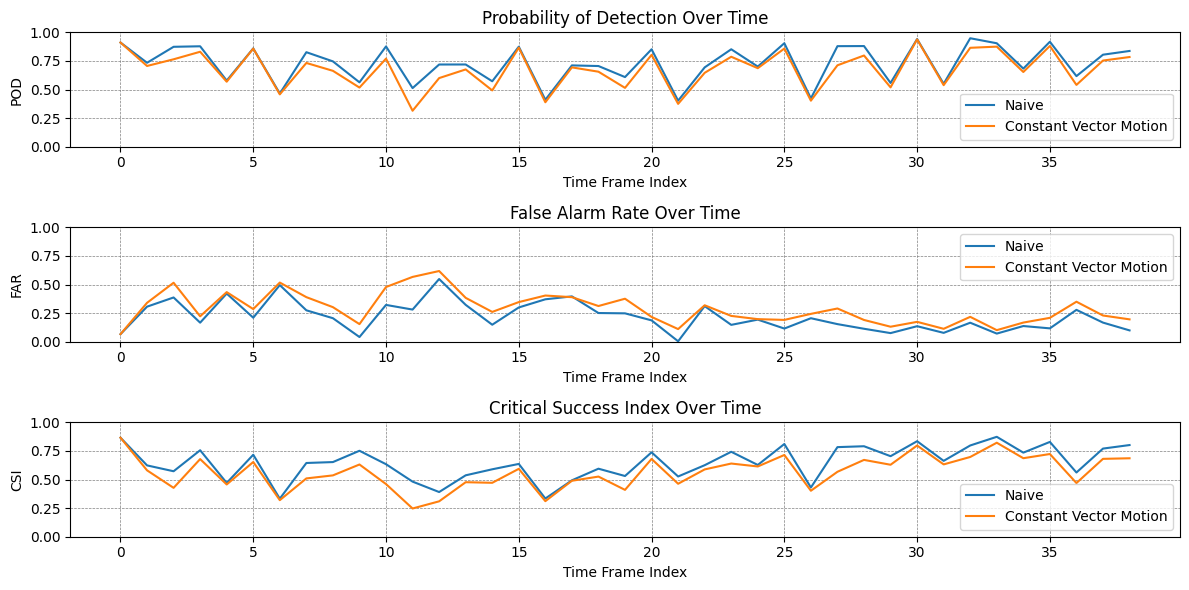

In [13]:
indexes = range(len(bm_pod_scores))
scores = [
    (bm_pod_scores, pod_scores), 
    (bm_far_scores, far_scores),
    (bm_csi_scores, csi_scores)
]
titles = ['Probability of Detection Over Time', 'False Alarm Rate Over Time', 'Critical Success Index Over Time']
ylabels = ['POD', 'FAR', 'CSI']

plt.figure(figsize=(12, 6))

for i, title in enumerate(titles):
    plt.subplot(3, 1, i+1)
    plt.plot(indexes, scores[i][0], label='Naive')
    plt.plot(indexes, scores[i][1], label='Constant Vector Motion')
    plt.title(title)
    plt.xlabel('Time Frame Index')
    plt.ylabel(ylabels[i])
    plt.ylim(0, 1)
    plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
    plt.legend()

plt.tight_layout()
plt.show()